In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import lightgbm as lgb

# ======================
# 1. CARGA DE DATOS
# ======================
df_coolers = pd.read_csv('coolers.csv')
df_warning = pd.read_csv('warnings.csv')
df_calendar = pd.read_csv('calendar.csv')
df_sales = pd.read_csv('sales.csv')


# ======================
# 2. LIMPIEZA Y FEATURE ENGINEERING
# ======================

df_coolers = df_coolers.dropna(subset=['door_opens', 'open_time'])
df_coolers = df_coolers.dropna(subset=['temperature'])
df_coolers = df_coolers.dropna(subset=['min_voltage'])
df_coolers = df_coolers[~((df_coolers['min_voltage'] == 0) & (df_coolers['max_voltage'] == 0))]

# Merge de warnings
df_warning['Warning'] = 1
df = pd.merge(df_coolers, df_warning, on='cooler_id', how='left')
df['Warning'] = df['Warning'].fillna(0).astype(int)

# Eliminar registros con voltajes nulos (sospechosos)
df = df[~((df['min_voltage'] == 0) & (df['max_voltage'] == 0))]

# Merge con calendario
df_calendar['calday'] = df_calendar['calday'].astype(str)
df['calday'] = df['calday'].astype(str)
df = df.merge(df_calendar.rename(columns={'day': 'week_day'}), on='calday', how='left')

# Fecha como datetime
df['date'] = pd.to_datetime(df['calday'], format='%Y%m%d')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Día de la semana en sin y cos (para ciclos)
df['week_day_num'] = df['date'].dt.weekday
df['week_day_sin'] = np.sin(2 * np.pi * df['week_day_num'] / 7)
df['week_day_cos'] = np.cos(2 * np.pi * df['week_day_num'] / 7)

# ======================
# 3. AGREGACIÓN MENSUAL POR COOLER
# ======================

# Agregamos por cooler, año y mes
monthly = df.groupby(['cooler_id', 'year', 'month']).agg({
    'door_opens': 'mean',
    'open_time': 'mean',
    'compressor': 'mean',
    'power': 'mean',
    'on_time': 'mean',
    'min_voltage': 'mean',
    'max_voltage': 'mean',
    'temperature': 'mean',
    'week_day_sin': 'mean',
    'week_day_cos': 'mean',
    'Warning': 'max'
}).reset_index()

# ======================
# 4. VENTAS
# ======================
df_sales['calmonth'] = df_sales['calmonth'].astype(str)
df_sales['year'] = df_sales['calmonth'].str[:4].astype(int)
df_sales['month'] = df_sales['calmonth'].str[4:6].astype(int)

sales_agg = df_sales.groupby(['cooler_id', 'year', 'month'])['amount'].sum().reset_index()
monthly = pd.merge(monthly, sales_agg, on=['cooler_id', 'year', 'month'], how='left')
monthly['amount'] = monthly['amount'].fillna(0)

# filtrar por los que no tienen amount pero si se habrio muchas veces el cooler (sospechosos) 6 rows
monthly = monthly[~((monthly['open_time'] == 0) & (monthly['amount'] > 0))]
# filtrar por los que no tienen open time pero si tienen amount (sospechosos) 10 rows
monthly = monthly[~((monthly['amount'] == 0) & (monthly['open_time'] > 40))]

# ======================
# 5. SEPARACIÓN DE ENTRENAMIENTO Y TEST
# ======================
# Excluir mayo 2025
train_df = monthly[(monthly['year'] != 2025)]
test_df = monthly[(monthly['year'] == 2025)]

X = train_df.drop(columns=['Warning', 'cooler_id', 'year', 'month'])
y = train_df['Warning']
X_test = test_df.drop(columns=['Warning', 'cooler_id', 'year', 'month'])

# ======================
# 6. MODELADO
# ======================
model = lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X, y)

# ======================
# 7. PREDICCIÓN PARA MAYO 2025
# ======================
probs = model.predict_proba(X_test)[:, 1]
pred_df = test_df[['cooler_id']].copy()
pred_df['probability'] = np.round(probs, 4)

# ======================
# 8. EXPORTACIÓN FINAL
# ======================
pred_df.to_csv('predicted_warnings_may2025.csv', index=False)
print(pred_df.head())


[LightGBM] [Info] Number of positive: 186, number of negative: 29725
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2788
[LightGBM] [Info] Number of data points in the train set: 29911, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
                                            cooler_id  probability
3   000c011eca9990bc07e6577a13dc0ad3bc0bb2e5b628f4...       0.0048
15  00190192bd70e98a2399c87c883f9abd122ddf1ea91515...       0.0772
27  0026be8ea32cc11fe427ed626def3096f35d0fbdb4da1c...       0.0203
40  00333a0aaa7e706c1c0dcf8571b415ebb00392bedbfa25...       0.2382
55  005241ae2ff948115acb4556ffb066ee3a37aa94f61d2f...       0.0111


In [254]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report

# Predicciones en training set
y_pred = model.predict(X)
y_proba = model.predict_proba(X)[:, 1]

# Matriz de confusión
print("Matriz de Confusión:")
print(confusion_matrix(y, y_pred))

# Métricas de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y, y_pred, digits=4))

# ROC AUC
roc_auc = roc_auc_score(y, y_proba)
print("\nROC AUC Score:", round(roc_auc, 4))


Matriz de Confusión:
[[17569   111]
 [    0   203]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0     1.0000    0.9937    0.9969     17680
           1     0.6465    1.0000    0.7853       203

    accuracy                         0.9938     17883
   macro avg     0.8232    0.9969    0.8911     17883
weighted avg     0.9960    0.9938    0.9944     17883


ROC AUC Score: 1.0


In [226]:
# Agrega las predicciones al DataFrame de entrenamiento
train_df_eval = train_df.copy()
train_df_eval['pred'] = y_pred
train_df_eval['proba'] = y_proba
train_df_eval['true'] = y.values

# Falsos positivos: predijo 1 pero era 0
false_positives = train_df_eval[(train_df_eval['true'] == 0) & (train_df_eval['pred'] == 1)]

print(f"Total falsos positivos: {false_positives.shape[0]}")
false_positives.head()


# Verdaderos positivos: predijo 0 pero era 0
true_positives = train_df_eval[(train_df_eval['true'] == 0) & (train_df_eval['pred'] == 0)]

print(f"Total falsos positivos: {true_positives.shape[0]}")
true_positives.head()

# Falsos positivos: predijo 1 pero era 0
false_positives = train_df_eval[(train_df_eval['true'] == 0) & (train_df_eval['pred'] == 1)]

# Verdaderos negativos: predijo 0 y era 0
true_negatives = train_df_eval[(train_df_eval['true'] == 0) & (train_df_eval['pred'] == 0)]

compare = pd.DataFrame({
    'Falsos Positivos': false_positives.mean(numeric_only=True),
    'Verdaderos Negativos': true_negatives.mean(numeric_only=True)
})
compare['Diferencia Relativa (%)'] = 100 * (compare['Falsos Positivos'] - compare['Verdaderos Negativos']) / compare['Verdaderos Negativos']
compare = compare.round(2)
print(compare)



Total falsos positivos: 111
Total falsos positivos: 17569
              Falsos Positivos  Verdaderos Negativos  Diferencia Relativa (%)
year                   2023.74               2023.76                    -0.00
month                     7.70                  8.43                    -8.57
door_opens               44.01                 54.38                   -19.08
open_time                 5.32                  7.36                   -27.81
compressor               50.37                 43.05                    17.01
power                   159.22                111.93                    42.24
on_time                  22.65                 19.81                    14.31
min_voltage             109.79                109.55                     0.22
max_voltage             124.90                127.19                    -1.80
temperature               6.13                  5.09                    20.44
week_day_sin              0.06                  0.02                   145.98
week_d

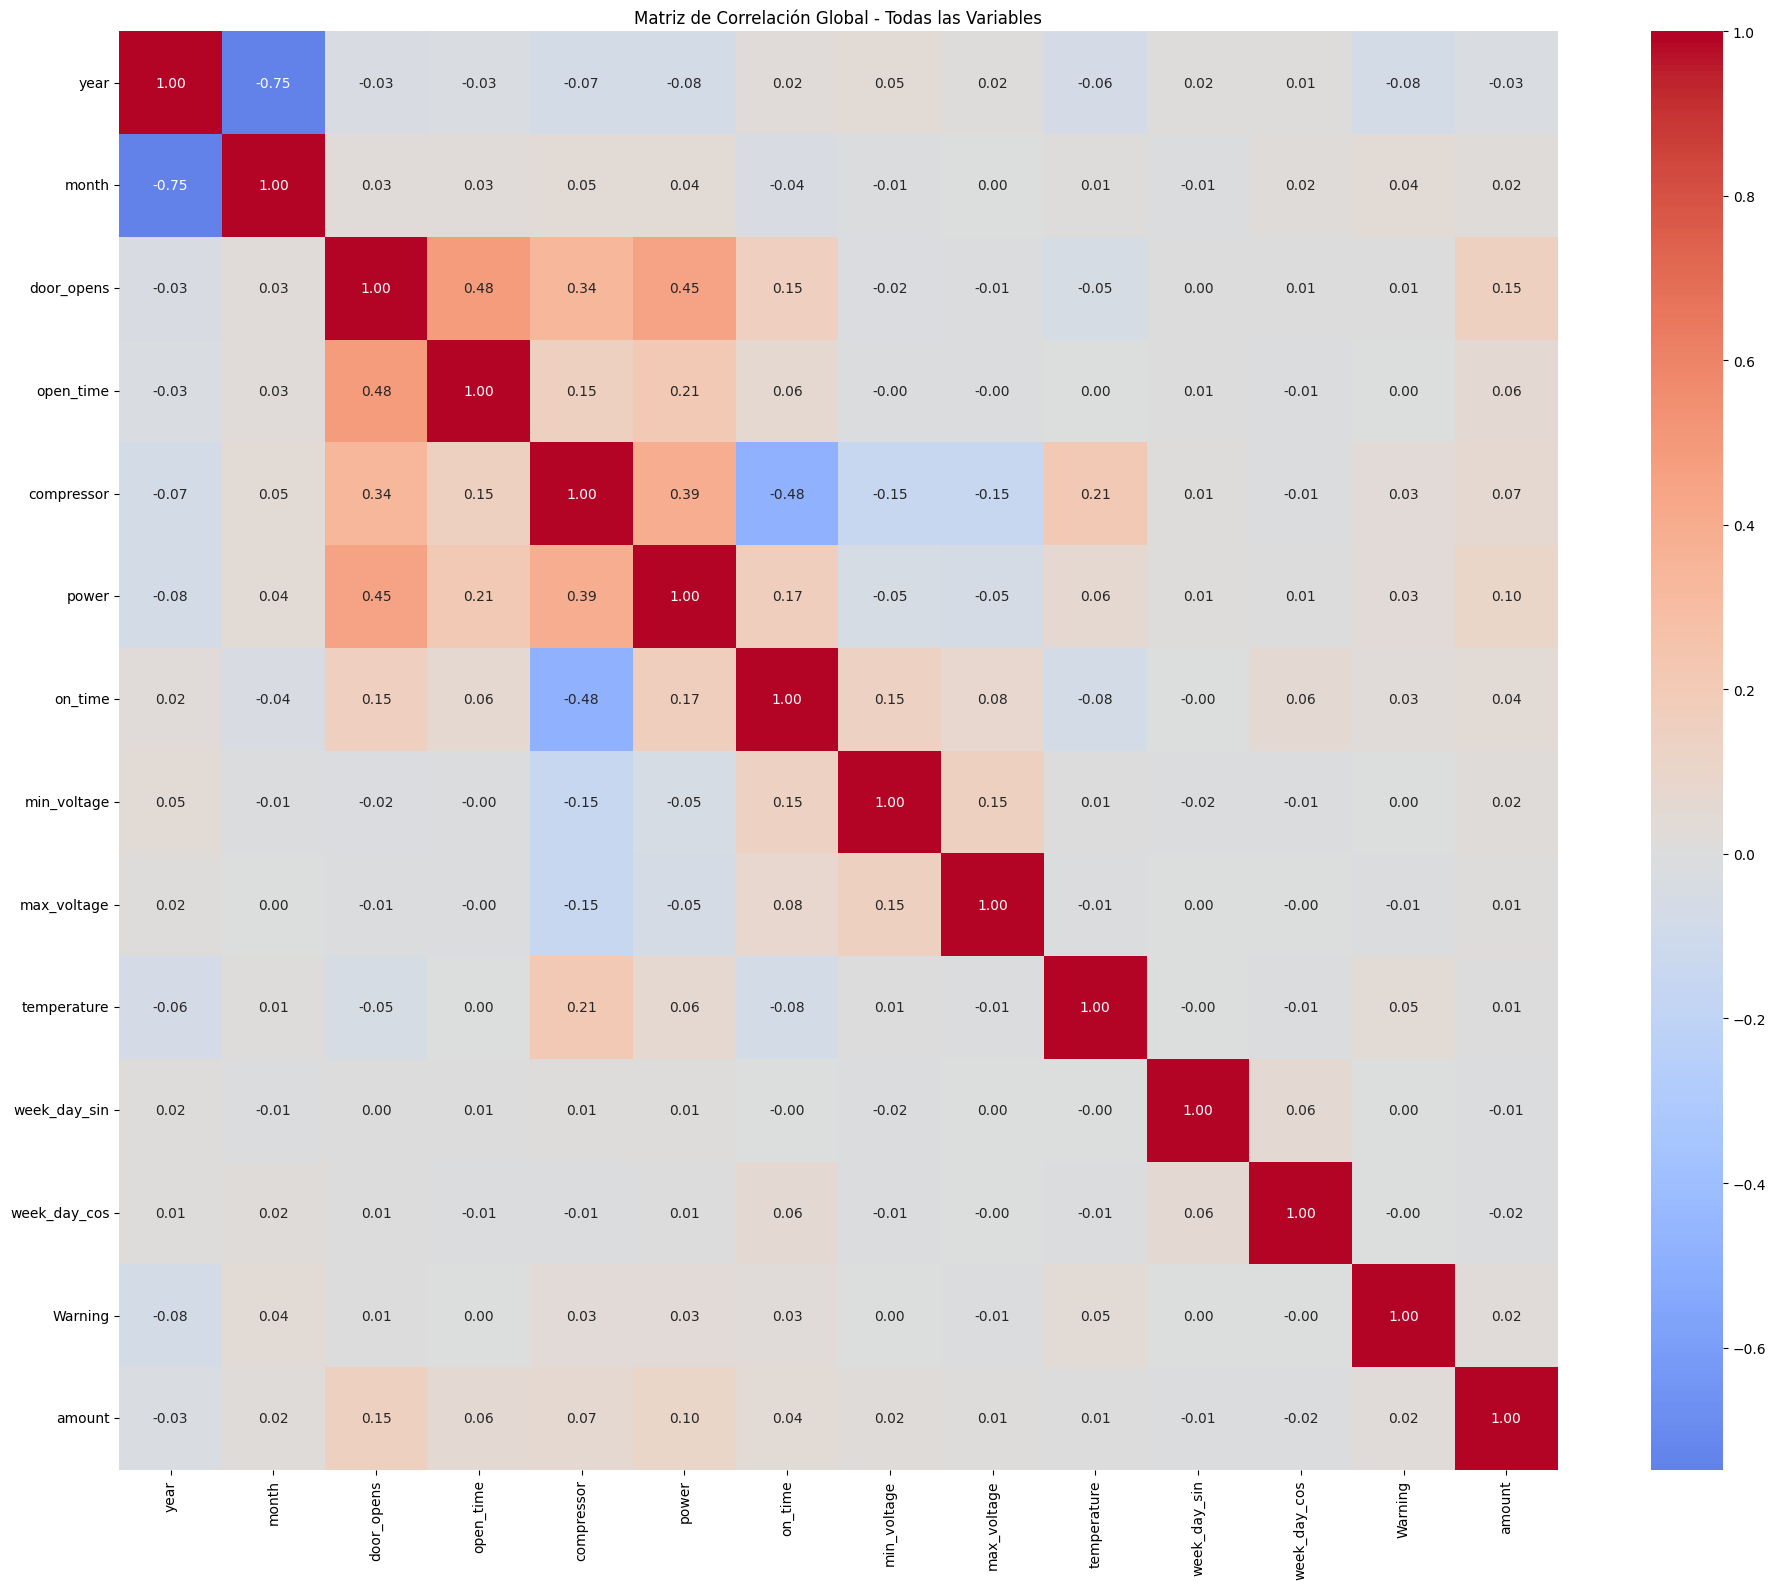

In [258]:
import matplotlib.pyplot as plt
import seaborn as sns
# 1. Matriz de Correlación Global con todas las características
def matriz_correlacion_completa(df):
    """
    Crea una matriz de correlación usando todas las variables numéricas del dataset
    """
    # Seleccionamos solo las columnas numéricas
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlation_matrix = df[numeric_cols].corr()
    
    # Creamos una figura más grande para acomodar todas las variables
    plt.figure(figsize=(20, 16))
    sns.heatmap(correlation_matrix, 
                annot=True,
                cmap='coolwarm',
                center=0,
                fmt='.2f',
                square=True,
                xticklabels=True,
                yticklabels=True)
    
    plt.title('Matriz de Correlación Global - Todas las Variables')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Llamas la función
matriz_correlacion_completa(monthly)